# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import os
from matplotlib import pyplot as plt
import numpy as np
import glob
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.8.0
/device:GPU:0


In [3]:
# Data loader
from utils import data_loader

# Data loader
from utils import data_loader

path_train = "data\LITS_Challenge\Training_Batch_2"
path_valid = "data\LITS_Challenge\Training_Batch_1"

loader_train = data_loader.NiiDataLoader(path_train)
loader_valid = data_loader.NiiDataLoader(path_valid)

train_generator = loader_train.data_generator_2d()
valid_generator = loader_valid.data_generator_2d()





counter_train = loader_train.generator_data_len()
counter_valid = loader_valid.generator_data_len()

print(counter_train)
print(counter_valid)

counter_train = 14635
counter_valid = 4510

initalised with path data\LITS_Challenge\Training_Batch_2
files: 103,103
initalised with path data\LITS_Challenge\Training_Batch_1
files: 28,28
103
28


In [3]:
### learning rate schedule

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch == 5:
        lr = 0.001
        return lr
    else:
        return lr * tf.math.exp(-0.05)

In [4]:
#datasets for tf
batch_size = 16
dataset = tf.data.Dataset.from_generator(
     loader_train.data_generator_2d,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])))
dataset = dataset.repeat(101).batch(batch_size)

valid_dataset = tf.data.Dataset.from_generator(
     loader_valid.data_generator_2d,
     (tf.float32,tf.float32), 
    (tf.TensorShape([256,256,1]), tf.TensorShape([256,256,2])))
valid_dataset = valid_dataset.repeat(100).batch(batch_size)#.shuffle(1000,  reshuffle_each_iteration=True)


print(dataset)
print(valid_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>


In [5]:
# Network set-up
from utils import models

model = models.model_call(model_name="2DUNET",px=256,features=16)

In [6]:
# Metrics and training
 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision_all = tf.keras.metrics.Precision(
    thresholds=0.5)
precision = tf.keras.metrics.Precision(
    thresholds=0.5, class_id=1)
recall = tf.keras.metrics.Recall(
    thresholds=0.5, class_id=1)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=[precision_all,precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 256, 256, 1)]           0           []                    
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16)            160         ['input_1[0][0]']     
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16)            2320        ['conv2d[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16)            0           ['conv2d_1[0][0]']    
                                                                                              

In [7]:
# Results
# reading checkpoint if needen
#
#################################

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler),
    ModelCheckpoint(
        "models\\2DUNET_liver\\{epoch:02d}-{val_loss:.4f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
]
epochs = 50
steps_per_epoch = (
    counter_train / batch_size
) 


validations_steps = counter_valid / batch_size

history = model.fit(
    dataset,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=0,
    epochs=epochs,
    validation_steps=validations_steps,
    steps_per_epoch=steps_per_epoch,
)

Epoch 1/50
 194/2732 [=>............................] - ETA: 10:25 - loss: 0.4986 - precision: 0.9783 - precision_1: 0.0014 - recall: 1.0866e-04

KeyboardInterrupt: 

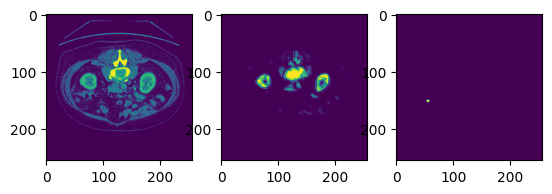

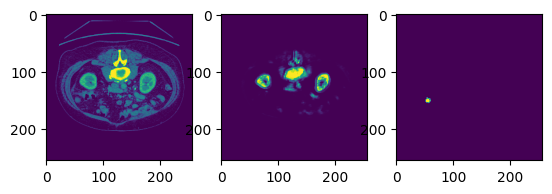

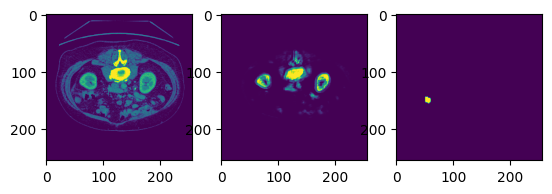

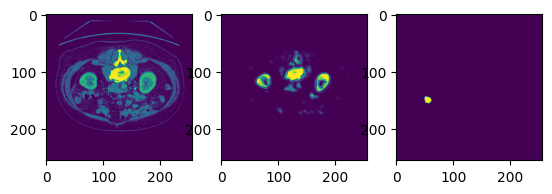

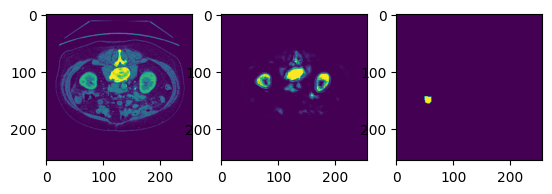

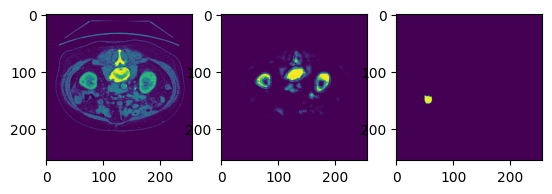

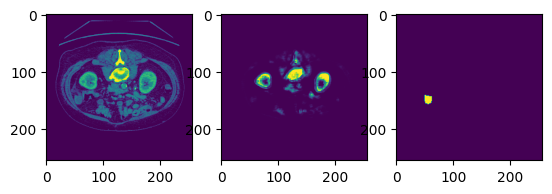

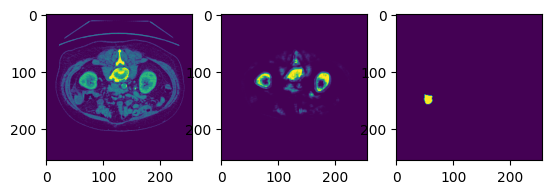

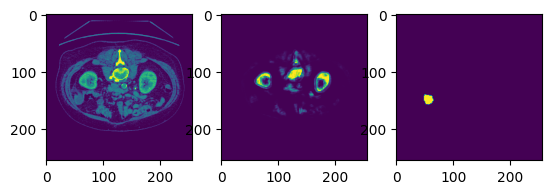

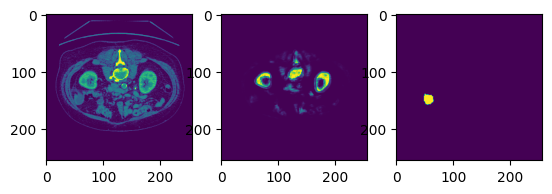

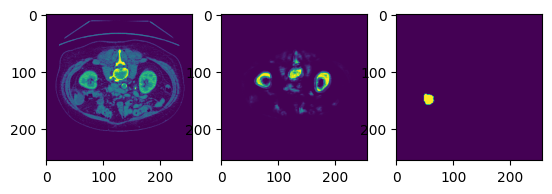

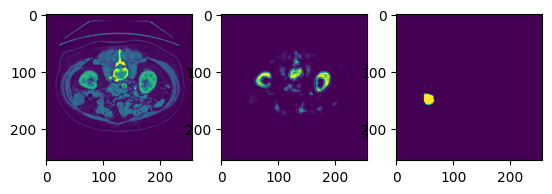

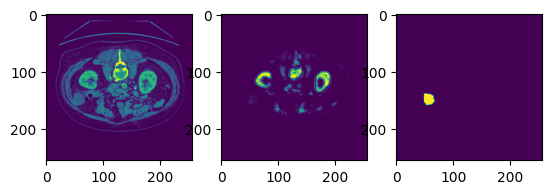

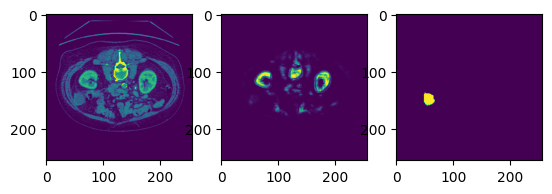

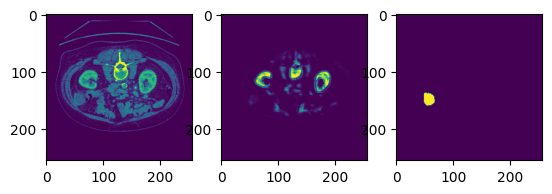

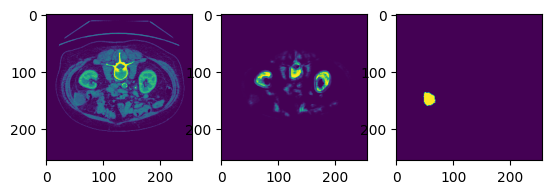

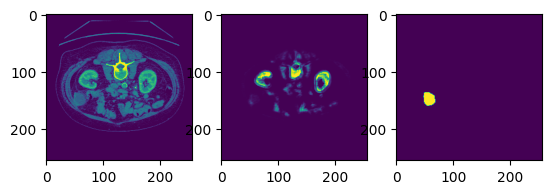

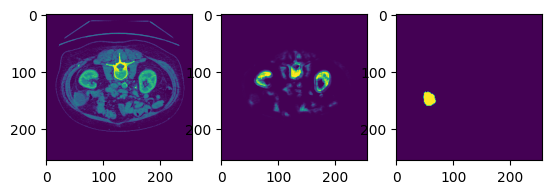

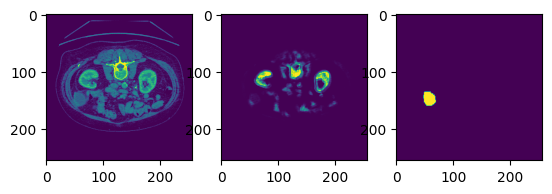

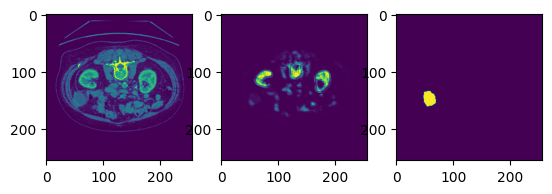

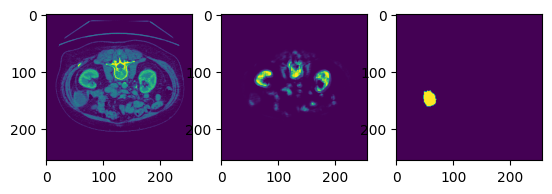

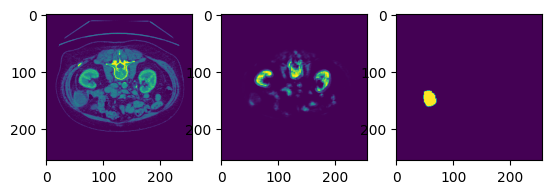

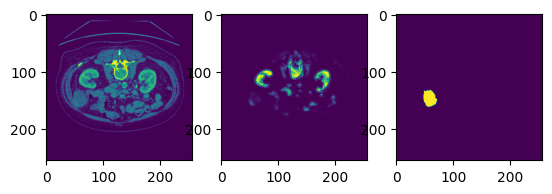

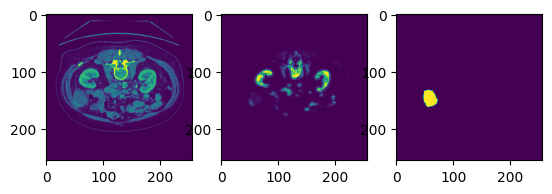

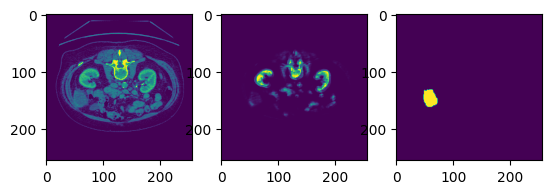

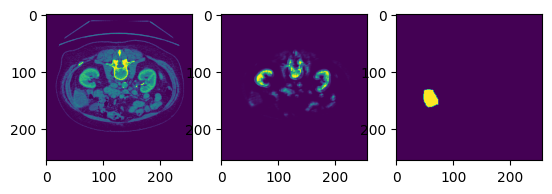

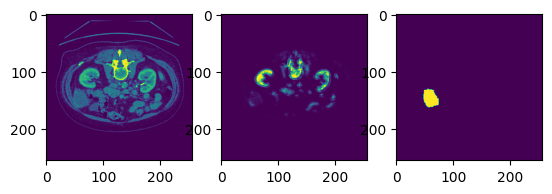

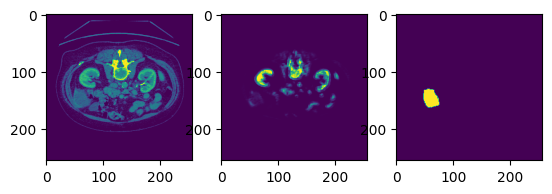

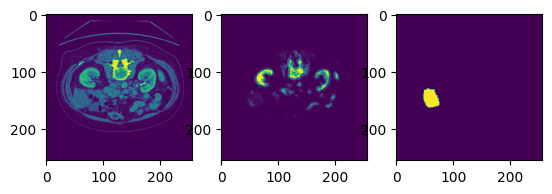

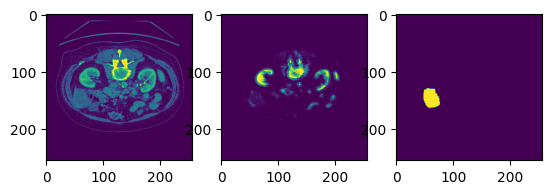

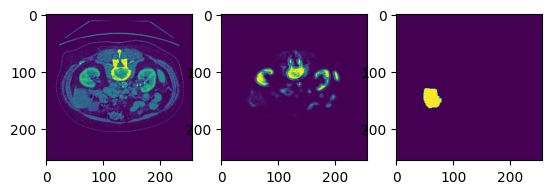

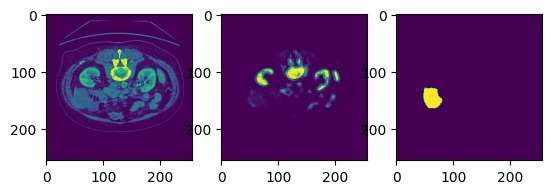

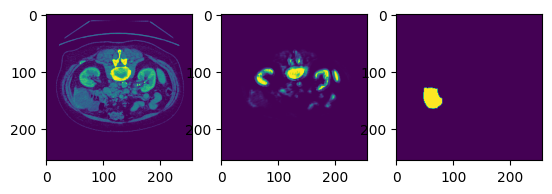

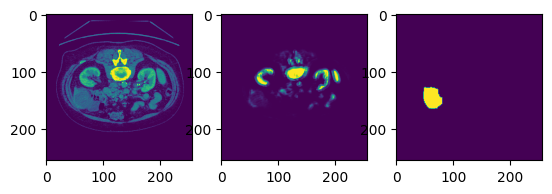

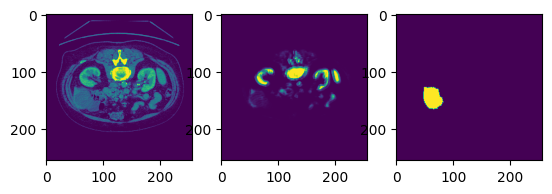

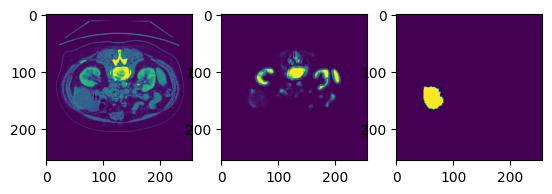

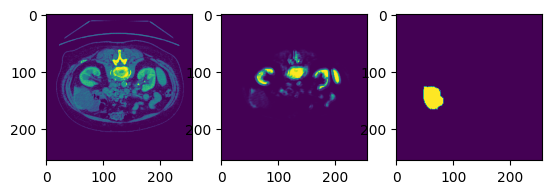

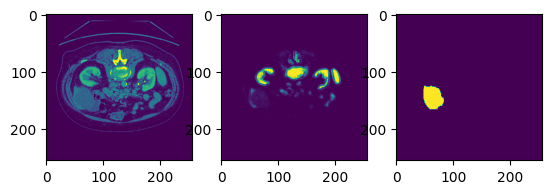

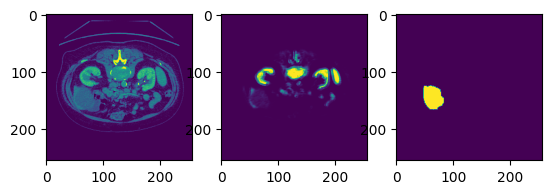

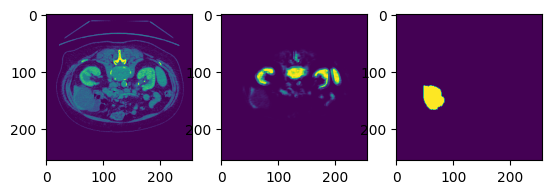

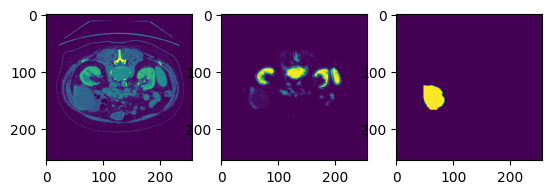

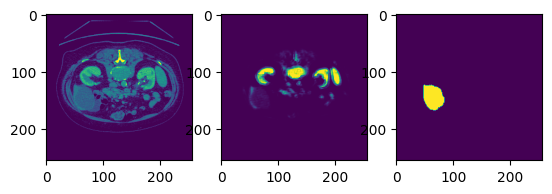

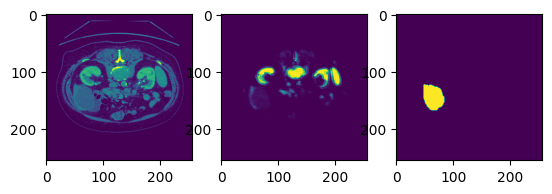

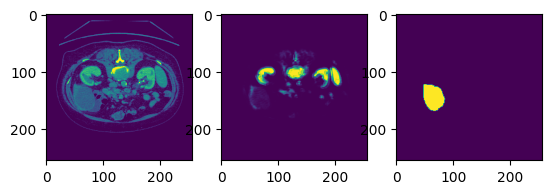

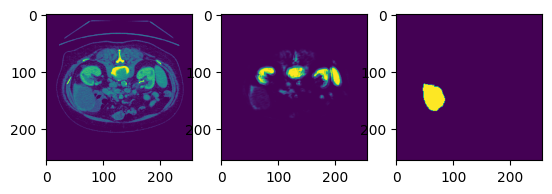

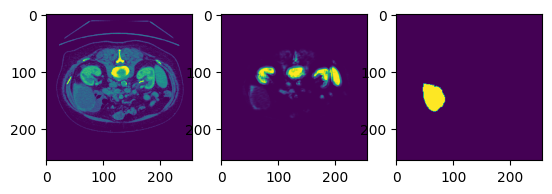

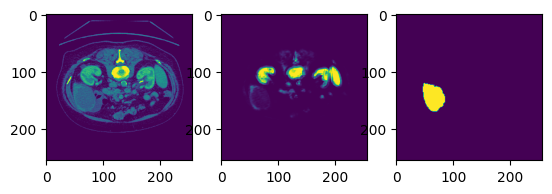

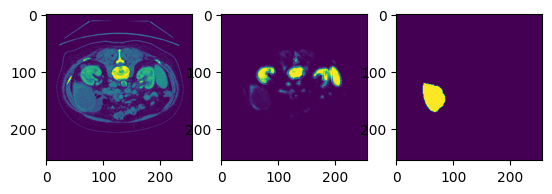

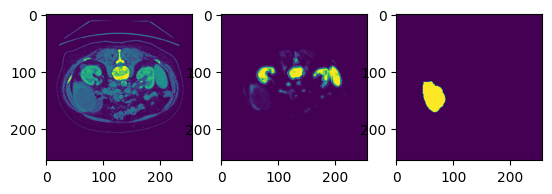

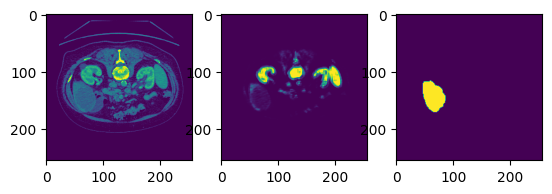

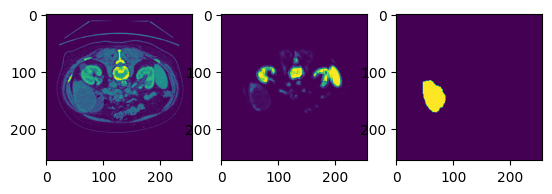

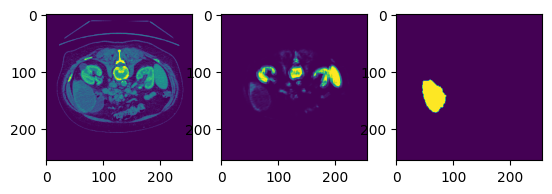

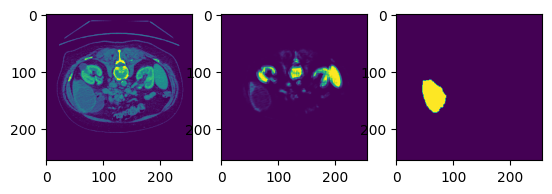

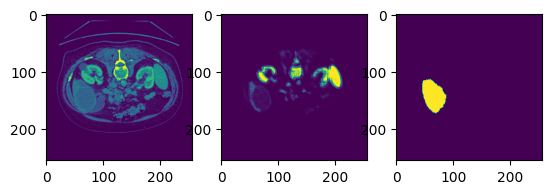

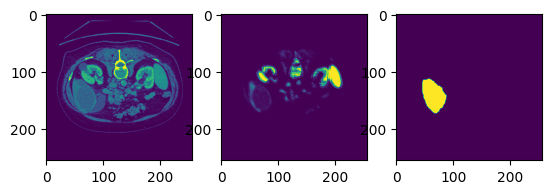

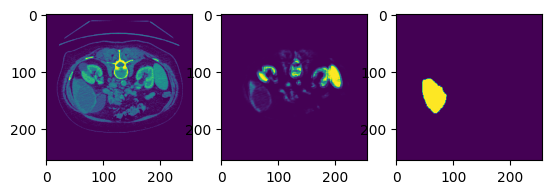

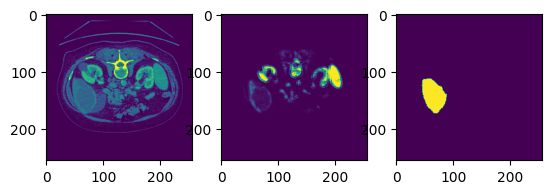

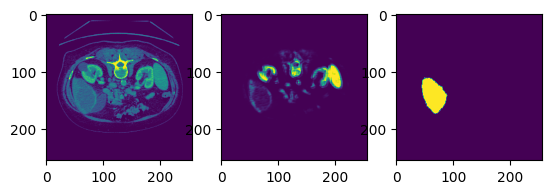

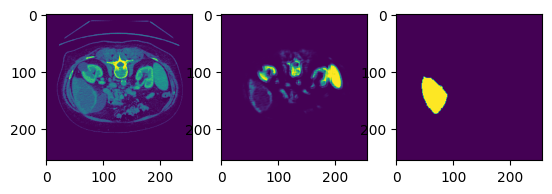

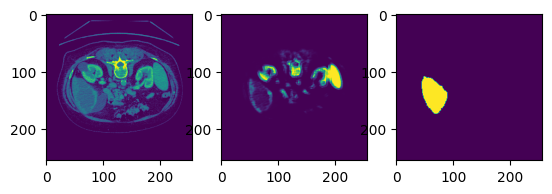

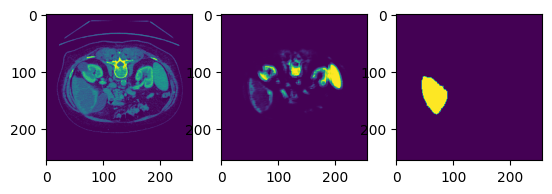

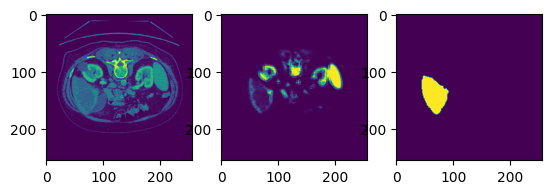

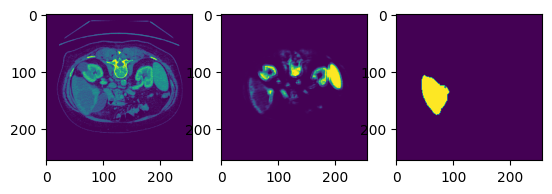

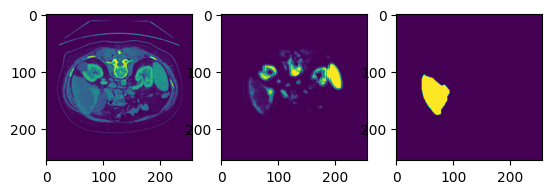

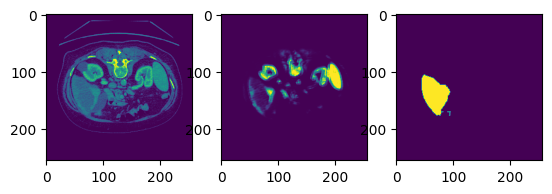

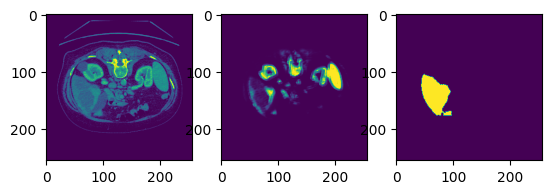

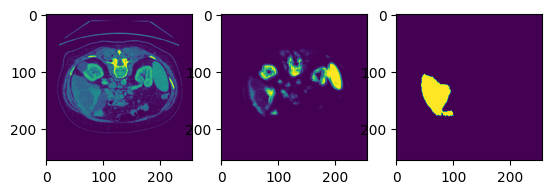

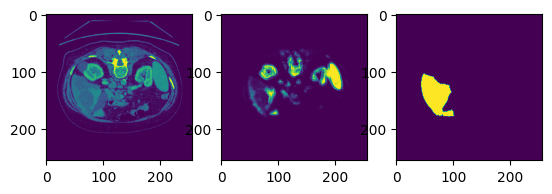

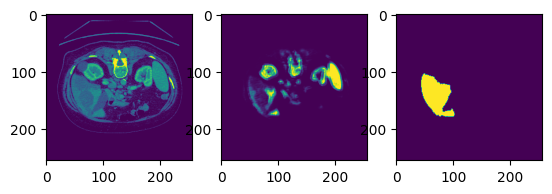

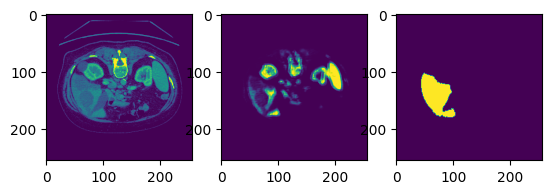

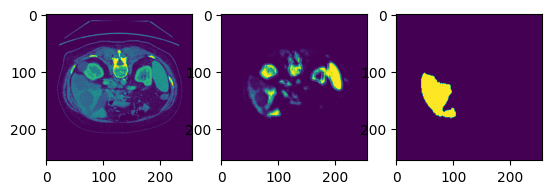

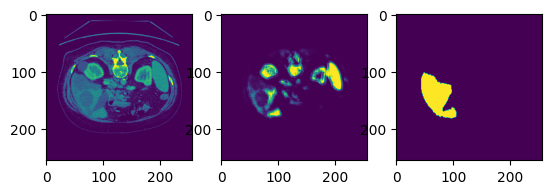

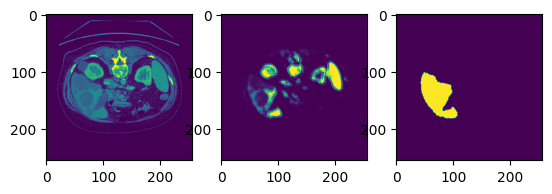

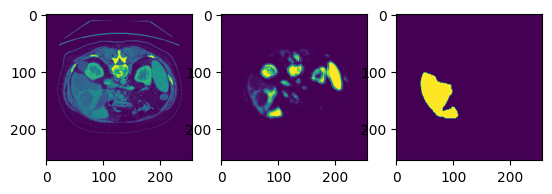

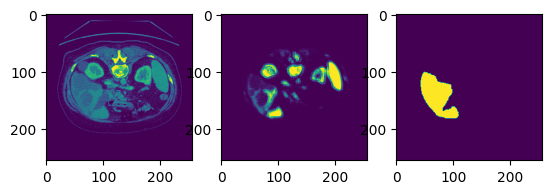

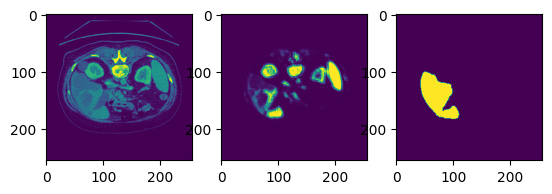

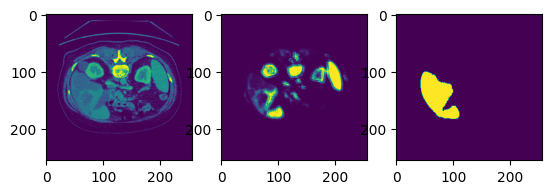

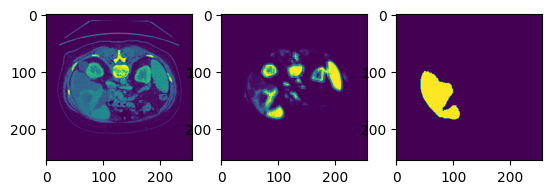

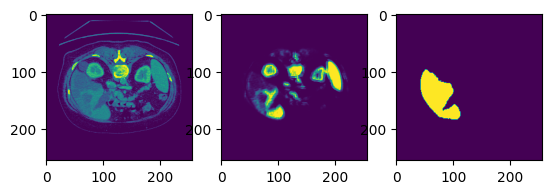

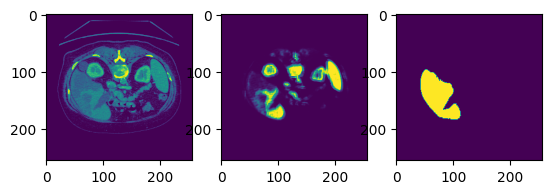

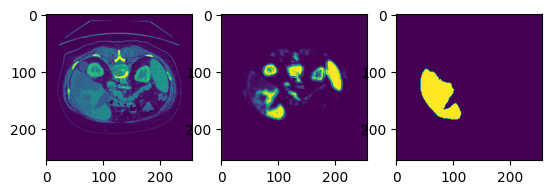

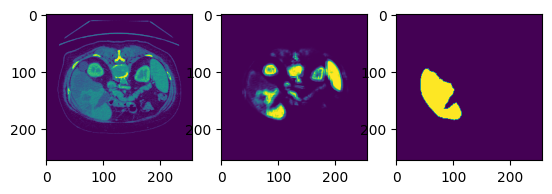

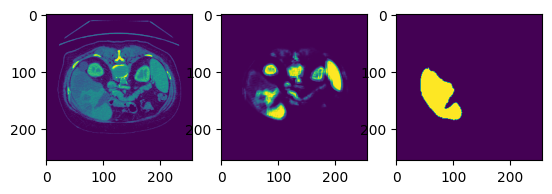

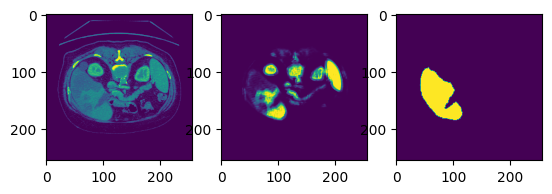

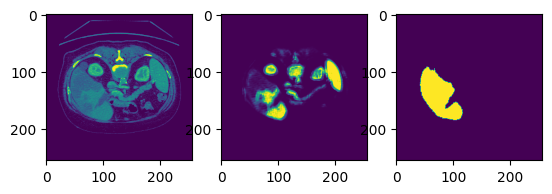

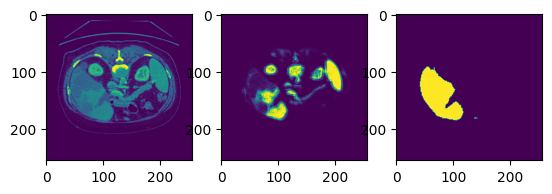

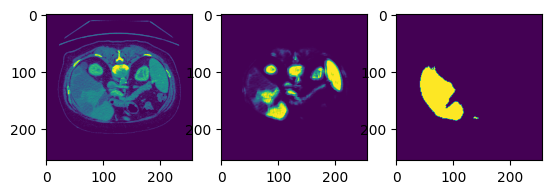

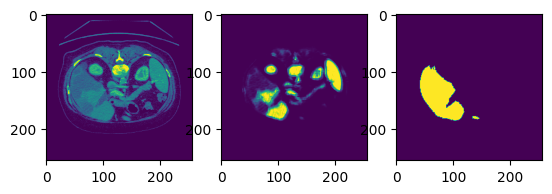

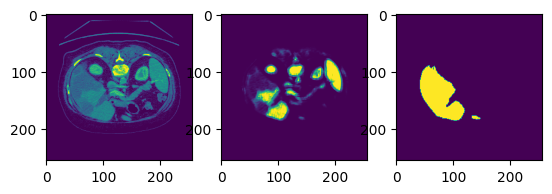

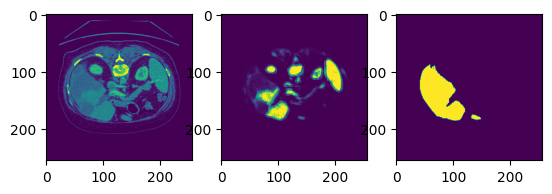

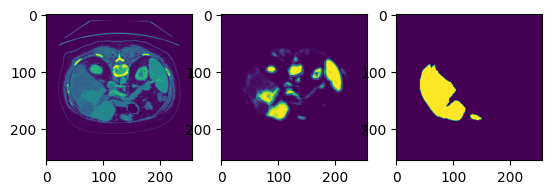

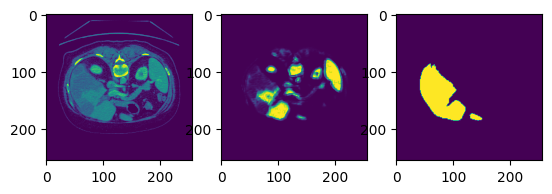

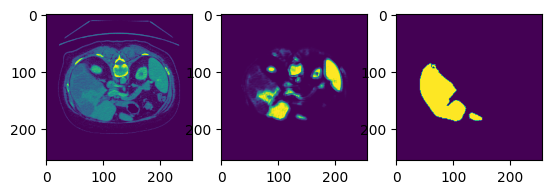

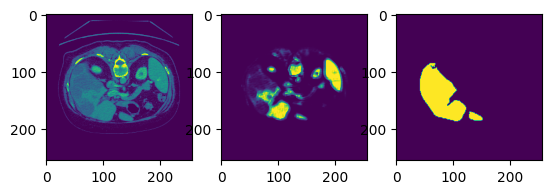

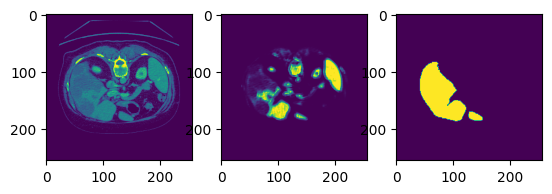

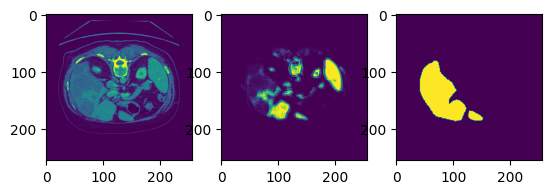

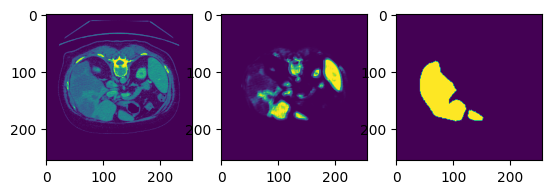

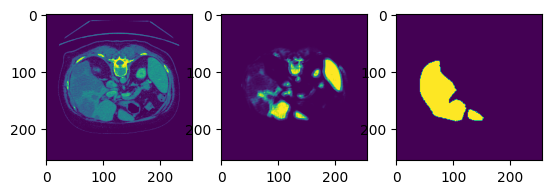

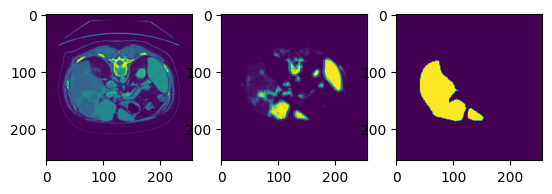

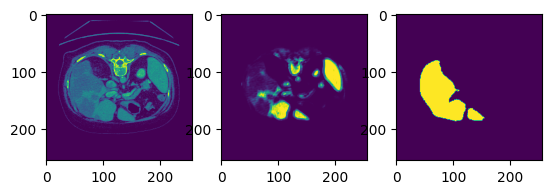

In [24]:
n_max = 100
n=0
for x in loader_valid.data_generator_2d:
   if n < n_max:
    plt.subplot(1,3,1)
    plt.imshow(x[0])
    plt.subplot(1,3,2)
    preds = model.predict(tf.reshape(x[0],[1,256,256,1]))
    plt.imshow(preds[0,:,:,1])
    plt.subplot(1,3,3)
    plt.imshow(x[1][:,:,1])
    plt.show()

   n+=1